# Non-Markovian Quantum Reservoir Computing

This notebook implements **quantum reservoir computing (QRC)** based on the Fujii-Nakajima approach, incorporating **non-Markovian dynamics** via time subordination.

## Architecture

1. **Input Layer**: Classical signal encoded into quantum system via time-dependent fields
2. **Reservoir**: Network of coupled spins with transverse-field Ising Hamiltonian
3. **Non-Markovianity**: Time subordination introduces memory effects
4. **Readout**: Linear regression on expectation values of Pauli operators

## Theory

**Reservoir Hamiltonian** (Fujii-Nakajima):
$$H(t) = H_{\text{res}} + H_{\text{input}}(t)$$

$$H_{\text{res}} = -J \sum_{\langle i,j \rangle} \sigma_i^z \sigma_j^z - h \sum_i \sigma_i^x$$

$$H_{\text{input}}(t) = \sum_i g_i u(t) \sigma_i^z$$

where:
- $J$ = coupling strength between neighboring spins
- $h$ = transverse field strength
- $g_i$ = input coupling coefficients
- $u(t)$ = input signal

**Non-Markovian Evolution**:
Under time subordination with parameter $\alpha \in (0,1]$, the dynamics acquire memory effects and anomalous diffusion properties.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import qutip as qt
from scipy.special import gamma as gamma_func
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

## Time Subordination Functions

Import the key algorithms from the non-Markovian framework.

In [3]:
def sample_positive_stable_subordinator(alpha):
    """
    Sample from a positive stable distribution with Laplace transform:
    E[exp(-lambda * S)] = exp(-lambda^alpha)
    
    Uses Chambers-Mallows-Stuck (CMS) method for stable distributions.
    For alpha in (0,1), this generates S_alpha ~ S(alpha, 1, 1, 0) 
    (stable with beta=1, totally skewed to the right).
    """
    if alpha == 1.0:
        return 1.0
    
    U = np.random.uniform(-np.pi/2, np.pi/2)
    W = np.random.exponential(1.0)
    
    # For beta=1 (totally skewed), zeta = xi = pi*alpha/2
    zeta = np.pi * alpha / 2.0
    xi = zeta
    
    numerator = np.sin(alpha * (U + xi))
    denominator = (np.cos(U)) ** (1.0 / alpha)
    
    factor1 = numerator / denominator
    factor2 = ((np.cos(U - alpha * (U + xi))) / W) ** ((1.0 - alpha) / alpha)
    
    S = factor1 * factor2
    
    if S <= 0 or not np.isfinite(S):
        return sample_positive_stable_subordinator(alpha)
    
    return S

def sample_operational_time_kws(t, alpha):
    """
    Kanter-Williams-Steiger (KWS) algorithm for inverse-stable (hitting-time) density.
    
    Samples u from the inverse-stable subordinator f_alpha(u,t) whose Laplace transform
    (with respect to u) is:
    L[f_alpha(u,t)](s) = exp(-t * s^alpha)
    
    This is the hitting-time density for an alpha-stable subordinator.
    
    Formula (KWS): u = t / S_alpha^(1/alpha)
    where S_alpha is a positive stable variable with E[exp(-lambda*S)] = exp(-lambda^alpha)
    """
    S = sample_positive_stable_subordinator(alpha)
    return t / (S ** (1.0 / alpha))

## Quantum Reservoir Architecture

Build the Fujii-Nakajima reservoir with transverse-field Ising Hamiltonian.

In [ ]:
class NonMarkovianQuantumReservoir:
    """
    Quantum Reservoir Computing with Non-Markovian Dynamics.
    Based on Fujii-Nakajima architecture with time subordination.
    """
    
    def __init__(self, n_spins=5, J=1.0, h=0.5, gamma=0.1, alpha=1.0,
                 input_scaling=0.3, n_samples=100, washout_steps=10):
        """
        Parameters:
        -----------
        n_spins : int
            Number of spins in the reservoir
        J : float
            Ising coupling strength
        h : float
            Transverse field strength
        gamma : float
            Dissipation rate
        alpha : float
            Non-Markovianity parameter (0 < alpha <= 1)
            alpha=1.0: Markovian, alpha<1.0: Non-Markovian
        input_scaling : float
            Scaling factor for input signal
        n_samples : int
            Number of Monte Carlo samples for time subordination
        washout_steps : int
            Number of initial time steps to discard (washout period)
        """
        self.n_spins = n_spins
        self.J = J
        self.h = h
        self.gamma = gamma
        self.alpha = alpha
        self.input_scaling = input_scaling
        self.n_samples = n_samples
        self.washout_steps = washout_steps
        self.dim = 2**n_spins
        
        # Build reservoir Hamiltonian
        self.H_reservoir = self._build_reservoir_hamiltonian()
        
        # Build collapse operators for dissipation
        self.c_ops = self._build_collapse_operators()
        
        # Input coupling coefficients (random but fixed)
        self.input_weights = np.random.randn(n_spins) * 0.5
        
        # Pauli operator observables for each spin
        self.observables = self._build_observables()
        
        print(f"Quantum Reservoir Initialized:")
        print(f"  Spins: {n_spins}, Hilbert space dim: {self.dim}")
        print(f"  Coupling J={J}, Field h={h}, Dissipation γ={gamma}")
        print(f"  Non-Markovianity: α={alpha}")
        print(f"  {'Markovian' if alpha == 1.0 else 'Non-Markovian'} regime")
        print(f"  Washout steps: {washout_steps}")
    
    def _build_reservoir_hamiltonian(self):
        """
        Build transverse-field Ising Hamiltonian:
        H_res = -J * sum_{<i,j>} σ_i^z σ_j^z - h * sum_i σ_i^x
        """
        H = 0
        
        # Ising interaction (nearest-neighbor chain)
        for i in range(self.n_spins - 1):
            sigma_z_i = self._pauli_z(i)
            sigma_z_j = self._pauli_z(i + 1)
            H -= self.J * sigma_z_i * sigma_z_j
        
        # Transverse field
        for i in range(self.n_spins):
            sigma_x_i = self._pauli_x(i)
            H -= self.h * sigma_x_i
        
        return H
    
    def _build_collapse_operators(self):
        """Build collapse operators for local dissipation on each spin."""
        c_ops = []
        for i in range(self.n_spins):
            # Local lowering operator for spin i
            c_op = np.sqrt(self.gamma) * self._destroy(i)
            c_ops.append(c_op)
        return c_ops
    
    def _build_observables(self):
        """Build Pauli operator observables for readout."""
        obs = []
        for i in range(self.n_spins):
            obs.append(self._pauli_x(i))
            obs.append(self._pauli_y(i))
            obs.append(self._pauli_z(i))
        return obs
    
    def _pauli_x(self, site):
        """Pauli X operator on specific site."""
        ops = [qeye(2)] * self.n_spins
        ops[site] = sigmax()
        return tensor(ops)
    
    def _pauli_y(self, site):
        """Pauli Y operator on specific site."""
        ops = [qeye(2)] * self.n_spins
        ops[site] = sigmay()
        return tensor(ops)
    
    def _pauli_z(self, site):
        """Pauli Z operator on specific site."""
        ops = [qeye(2)] * self.n_spins
        ops[site] = sigmaz()
        return tensor(ops)
    
    def _destroy(self, site):
        """Lowering operator on specific site."""
        ops = [qeye(2)] * self.n_spins
        ops[site] = destroy(2)
        return tensor(ops)
    
    def _input_hamiltonian(self, u_t):
        """
        Build input Hamiltonian: H_input(t) = sum_i g_i * u(t) * σ_i^z
        """
        H_input = 0
        for i in range(self.n_spins):
            H_input += self.input_weights[i] * u_t * self._pauli_z(i)
        return self.input_scaling * H_input
    
    def evolve_step(self, rho, u_t, dt):
        """
        Evolve reservoir for one time step with input u_t.
        Uses time subordination for non-Markovian dynamics.
        
        Parameters:
        -----------
        rho : Qobj
            Current density matrix
        u_t : float
            Input signal at time t
        dt : float
            Time step
            
        Returns:
        --------
        rho_next : Qobj
            Density matrix at t + dt
        """
        # Total Hamiltonian with input
        H_total = self.H_reservoir + self._input_hamiltonian(u_t)
        
        if self.alpha == 1.0:
            # Markovian evolution (standard mesolve)
            result = mesolve(H_total, rho, [0, dt], self.c_ops, 
                           options={'nsteps': 10000})
            return result.states[-1]
        else:
            # Non-Markovian evolution via time subordination
            return self._fractional_evolve(rho, H_total, dt)
    
    def _fractional_evolve(self, rho_0, H, dt, max_u=100):
        """
        Fractional evolution via time subordination Monte Carlo.
        
        Averages over random operational times u ~ f_alpha(u, dt) to implement
        the fractional dynamics. Each sample evolves for time u instead of dt.
        """
        rho_accumulated = 0 * rho_0
        samples_collected = 0
        attempts = 0
        max_attempts = self.n_samples * 5
        
        while samples_collected < self.n_samples and attempts < max_attempts:
            attempts += 1
            
            try:
                # Sample operational time from inverse stable distribution
                u = sample_operational_time_kws(dt, self.alpha)
                
                # Reject samples that are too large (numerical stability)
                if u > max_u or u <= 0:
                    continue
                
                # Evolve for operational time u
                result = mesolve(H, rho_0, [0, u], self.c_ops, 
                               options={'nsteps': 10000})
                rho_u = result.states[-1]
                rho_accumulated += rho_u
                samples_collected += 1
                
            except (ValueError, RuntimeError) as e:
                # Skip failed evolutions (e.g., numerical issues)
                continue
        
        if samples_collected < self.n_samples:
            print(f"Warning: Only {samples_collected}/{self.n_samples} samples collected")
        
        # Average and normalize
        rho_avg = rho_accumulated / samples_collected
        
        # Ensure trace normalization (important for numerical stability)
        tr = rho_avg.tr()
        if abs(tr - 1.0) > 1e-6:
            print(f"Warning: Trace = {tr:.6f}, renormalizing")
            rho_avg = rho_avg / tr
        
        return rho_avg
    
    def compute_observables(self, rho):
        """Compute expectation values of all Pauli observables."""
        return np.array([expect(obs, rho) for obs in self.observables])
    
    def process_input_sequence(self, input_signal, dt=0.1, return_washout=False):
        """
        Process an input signal through the reservoir.
        
        Parameters:
        -----------
        input_signal : array
            Input time series u(t)
        dt : float
            Time step
        return_washout : bool
            If True, return all states including washout period.
            If False (default), only return states after washout.
            
        Returns:
        --------
        states : array
            Reservoir states (observable expectations) at each time.
            Shape: (n_steps - washout_steps, n_features) if return_washout=False
                   (n_steps, n_features) if return_washout=True
        """
        # Initial state: all spins pointing down |00...0⟩
        psi_0 = tensor([basis(2, 0) for _ in range(self.n_spins)])
        rho = ket2dm(psi_0)
        
        states = []
        
        for t_idx, u_t in enumerate(input_signal):
            # Evolve with current input
            rho = self.evolve_step(rho, u_t, dt)
            
            # Compute observables after evolution
            obs = self.compute_observables(rho)
            states.append(obs)
            
            if (t_idx + 1) % 10 == 0:
                print(f"  Processed {t_idx + 1}/{len(input_signal)} steps")
        
        states = np.array(states)
        
        # Apply washout: discard initial transient states
        if not return_washout and self.washout_steps > 0:
            if len(states) <= self.washout_steps:
                print(f"Warning: Signal length ({len(states)}) <= washout ({self.washout_steps})")
                return states
            print(f"  Applying washout: discarding first {self.washout_steps} steps")
            states = states[self.washout_steps:]
        
        return states

## Benchmark Task: NARMA-10

Test the reservoir on the NARMA-10 (Nonlinear Auto-Regressive Moving Average) task, a standard benchmark for reservoir computing.

In [5]:
def generate_narma_p(n_samples,p, scale=0.5):
    # p = 10 recovers narma10
    """
    Generate NARMA-p time series.
    
    y(t+1) = 0.3*y(t) + 0.05*y(t)*sum_{i=0}^(p-1) y(t-i) + 1.5*u(t-(p+1))*u(t) + 0.1
    
    This is a standard benchmark for temporal processing systems.
    """
    u = np.random.uniform(0, scale, n_samples + p)
    y = np.zeros(n_samples + p)
    
    for t in range(p, n_samples + p):
        y[t] = (0.3 * y[t-1] + 
                0.05 * y[t-1] * np.sum(y[t-p:t]) + 
                1.5 * u[t-(p-1)] * u[t] + 
                0.1)
    
    return u[p:], y[p:]

# Generate one continuous NARMA-10 time series and split into train/test
n_train = 200
n_test = 60
n_total = n_train + n_test

p = 2
print(f"Generating NARMA-{p} dataset...")
u_full, y_full = generate_narma_p(n_total, p = p)

# Split into training and test sets
u_train = u_full[:n_train]
y_train = y_full[:n_train]
u_test = u_full[n_train:]
y_test = y_full[n_train:]

print(f"Total samples: {n_total}")
print(f"Training samples: {n_train}")
print(f"Test samples: {n_test}")
print(f"Input range: [{u_full.min():.3f}, {u_full.max():.3f}]")
print(f"Target range: [{y_full.min():.3f}, {y_full.max():.3f}]")
print("Note: Test set continues from where training set ends (continuous time series)")

Generating NARMA-2 dataset...
Total samples: 260
Training samples: 200
Test samples: 60
Input range: [0.003, 0.495]
Target range: [0.151, 0.605]
Note: Test set continues from where training set ends (continuous time series)


## Train Quantum Reservoir (Markovian)

In [6]:
# Create Markovian reservoir with washout
washout = 20  # Discard first 20 steps to eliminate initial transients

qrc_markov = NonMarkovianQuantumReservoir(
    n_spins=4,
    J=1.0,
    h=0.1,
    gamma=0.4,
    alpha=1.0,  # Markovian
    input_scaling=1,
    n_samples=1000,  # Not used for alpha=1.0
    washout_steps=washout
)

print("\n" + "="*60)
print("Processing training data (Markovian)...")
print("="*60)
X_train_markov = qrc_markov.process_input_sequence(u_train, dt=0.1)
# Trim targets to match states after washout
y_train_trimmed = y_train[washout:]

print(f"After washout: {len(X_train_markov)} states, {len(y_train_trimmed)} targets")

Quantum Reservoir Initialized:
  Spins: 4, Hilbert space dim: 16
  Coupling J=1.0, Field h=0.1, Dissipation γ=0.4
  Non-Markovianity: α=1.0
  Markovian regime
  Washout steps: 20

Processing training data (Markovian)...
  Processed 10/200 steps
  Processed 20/200 steps
  Processed 30/200 steps
  Processed 40/200 steps
  Processed 50/200 steps
  Processed 60/200 steps
  Processed 70/200 steps
  Processed 80/200 steps
  Processed 90/200 steps
  Processed 100/200 steps
  Processed 110/200 steps
  Processed 120/200 steps
  Processed 130/200 steps
  Processed 140/200 steps
  Processed 150/200 steps
  Processed 160/200 steps
  Processed 170/200 steps
  Processed 180/200 steps
  Processed 190/200 steps
  Processed 200/200 steps
  Applying washout: discarding first 20 steps
After washout: 180 states, 180 targets


## Train Readout Layer (Markovian)

In [7]:
# Train linear readout with Ridge regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_markov)

#readout = Ridge(alpha=1e-11)
readout = LinearRegression()
readout.fit(X_train_scaled, y_train_trimmed)

y_pred_train = readout.predict(X_train_scaled)
train_mse = mean_squared_error(y_train_trimmed, y_pred_train)
train_nmse = train_mse / np.var(y_train_trimmed)

print(f"\nTraining Results (Markovian):")
print(f"  MSE: {train_mse:.6f}")
print(f"  NMSE: {train_nmse:.6f}")
print(f"  Feature dimension: {X_train_markov.shape[1]} (3 Pauli ops × {qrc_markov.n_spins} spins)")


Training Results (Markovian):
  MSE: 0.008119
  NMSE: 0.750060
  Feature dimension: 12 (3 Pauli ops × 4 spins)


## Test Quantum Reservoir (Markovian)

In [8]:
print("\n" + "="*60)
print("Processing test data (Markovian)...")
print("="*60)
X_test_markov = qrc_markov.process_input_sequence(u_test, dt=0.1)
# Trim test targets to match states after washout
y_test_trimmed = y_test[washout:]

X_test_scaled = scaler.transform(X_test_markov)
y_pred_test = readout.predict(X_test_scaled)

test_mse = mean_squared_error(y_test_trimmed, y_pred_test)
test_nmse = test_mse / np.var(y_test_trimmed)

print(f"\nTest Results (Markovian):")
print(f"  MSE: {test_mse:.6f}")
print(f"  NMSE: {test_nmse:.6f}")


Processing test data (Markovian)...
  Processed 10/60 steps
  Processed 20/60 steps
  Processed 30/60 steps
  Processed 40/60 steps
  Processed 50/60 steps
  Processed 60/60 steps
  Applying washout: discarding first 20 steps

Test Results (Markovian):
  MSE: 0.099446
  NMSE: 7.282200


## Train Non-Markovian Reservoir (α = 0.7)

Now test with non-Markovian dynamics to see if memory effects improve performance.

In [9]:
# Create Non-Markovian reservoir with same washout
qrc_nonmarkov = NonMarkovianQuantumReservoir(
    n_spins=5,
    J=1.0,
    h=0.1,
    gamma=0.0,
    alpha=0.5,  # Non-Markovian
    input_scaling=1,
    n_samples=1000,  # Monte Carlo samples for time subordination
    washout_steps=washout
)

print("\n" + "="*60)
print("Processing training data (Non-Markovian α=0.7)...")
print("="*60)
X_train_nonmarkov = qrc_nonmarkov.process_input_sequence(u_train, dt=0.1)

Quantum Reservoir Initialized:
  Spins: 5, Hilbert space dim: 32
  Coupling J=1.0, Field h=0.1, Dissipation γ=0.0
  Non-Markovianity: α=0.5
  Non-Markovian regime
  Washout steps: 20

Processing training data (Non-Markovian α=0.7)...
  Processed 10/200 steps
  Processed 20/200 steps
  Processed 30/200 steps
  Processed 40/200 steps
  Processed 50/200 steps
  Processed 60/200 steps
  Processed 70/200 steps
  Processed 80/200 steps
  Processed 90/200 steps
  Processed 100/200 steps
  Processed 110/200 steps
  Processed 120/200 steps
  Processed 130/200 steps
  Processed 140/200 steps
  Processed 150/200 steps
  Processed 160/200 steps
  Processed 170/200 steps
  Processed 180/200 steps
  Processed 190/200 steps
  Processed 200/200 steps
  Applying washout: discarding first 20 steps


## Train Readout Layer (Non-Markovian)

In [10]:
scaler_nm = StandardScaler()
X_train_nm_scaled = scaler_nm.fit_transform(X_train_nonmarkov)

#readout_nm = Ridge(alpha=1e-11)
readout_nm = LinearRegression()
readout_nm.fit(X_train_nm_scaled, y_train_trimmed)

y_pred_train_nm = readout_nm.predict(X_train_nm_scaled)
train_mse_nm = mean_squared_error(y_train_trimmed, y_pred_train_nm)
train_nmse_nm = train_mse_nm / np.var(y_train_trimmed)

print(f"\nTraining Results (Non-Markovian α=0.7):")
print(f"  MSE: {train_mse_nm:.6f}")
print(f"  NMSE: {train_nmse_nm:.6f}")


Training Results (Non-Markovian α=0.7):
  MSE: 0.001825
  NMSE: 0.168630


## Test Non-Markovian Reservoir

In [13]:

print("\n" + "="*60)
print("Processing test data (Non-Markovian α=0.7)...")
print("="*60)
X_test_nonmarkov = qrc_nonmarkov.process_input_sequence(u_test, dt=0.1)

X_test_nm_scaled = scaler_nm.transform(X_test_nonmarkov)
y_pred_test_nm = readout_nm.predict(X_test_nm_scaled)

test_mse_nm = mean_squared_error(y_test_trimmed, y_pred_test_nm)
test_nmse_nm = test_mse_nm / np.var(y_test_trimmed)

print(f"\nTest Results (Non-Markovian α=0.7):")
print(f"  MSE: {test_mse_nm:.6f}")
print(f"  NMSE: {test_nmse_nm:.6f}")



Processing test data (Non-Markovian α=0.7)...
  Processed 10/60 steps
  Processed 20/60 steps
  Processed 30/60 steps
  Processed 40/60 steps
  Processed 50/60 steps
  Processed 60/60 steps
  Applying washout: discarding first 20 steps

Test Results (Non-Markovian α=0.7):
  MSE: 0.006728
  NMSE: 0.492677


## Comparison and Visualization

NameError: name 'y_pred_test_nm' is not defined

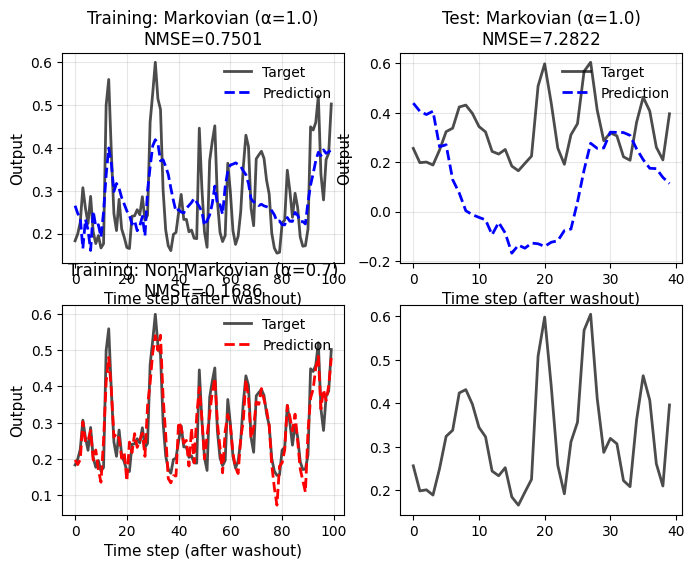

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6))

# Limit plot ranges
train_steps = 100  # Show first 100 steps for training
test_steps = 50    # Show first 50 steps for test

# Training results - Markovian
axes[0, 0].plot(y_train_trimmed[:train_steps], 'k-', label='Target', linewidth=2, alpha=0.7)
axes[0, 0].plot(y_pred_train[:train_steps], 'b--', label='Prediction', linewidth=2)
axes[0, 0].set_title(f'Training: Markovian (α=1.0)\nNMSE={train_nmse:.4f}', fontsize=12)
axes[0, 0].set_xlabel('Time step (after washout)', fontsize=11)
axes[0, 0].set_ylabel('Output', fontsize=11)
axes[0, 0].legend(fontsize=10, frameon=False)
axes[0, 0].grid(True, alpha=0.3)

# Test results - Markovian
axes[0, 1].plot(y_test_trimmed[:test_steps], 'k-', label='Target', linewidth=2, alpha=0.7)
axes[0, 1].plot(y_pred_test[:test_steps], 'b--', label='Prediction', linewidth=2)
axes[0, 1].set_title(f'Test: Markovian (α=1.0)\nNMSE={test_nmse:.4f}', fontsize=12)
axes[0, 1].set_xlabel('Time step (after washout)', fontsize=11)
axes[0, 1].set_ylabel('Output', fontsize=11)
axes[0, 1].legend(fontsize=10, frameon=False)
axes[0, 1].grid(True, alpha=0.3)

# Training results - Non-Markovian
axes[1, 0].plot(y_train_trimmed[:train_steps], 'k-', label='Target', linewidth=2, alpha=0.7)
axes[1, 0].plot(y_pred_train_nm[:train_steps], 'r--', label='Prediction', linewidth=2)
axes[1, 0].set_title(f'Training: Non-Markovian (α=0.7)\nNMSE={train_nmse_nm:.4f}', fontsize=12)
axes[1, 0].set_xlabel('Time step (after washout)', fontsize=11)
axes[1, 0].set_ylabel('Output', fontsize=11)
axes[1, 0].legend(fontsize=10, frameon=False)
axes[1, 0].grid(True, alpha=0.3)

# Test results - Non-Markovian
axes[1, 1].plot(y_test_trimmed[:test_steps], 'k-', label='Target', linewidth=2, alpha=0.7)
axes[1, 1].plot(y_pred_test_nm[:test_steps], 'r--', label='Prediction', linewidth=2)
axes[1, 1].set_title(f'Test: Non-Markovian (α=0.7)\nNMSE={test_nmse_nm:.4f}', fontsize=12)
axes[1, 1].set_xlabel('Time step (after washout)', fontsize=11)
axes[1, 1].set_ylabel('Output', fontsize=11)
axes[1, 1].legend(fontsize=10, frameon=False)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/quantum_reservoir_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Markovian (α=1.0):")
print(f"  Train NMSE: {train_nmse:.6f}")
print(f"  Test NMSE:  {test_nmse:.6f}")
print(f"\nNon-Markovian (α=0.5):")
print(f"  Train NMSE: {train_nmse_nm:.6f}")
print(f"  Test NMSE:  {test_nmse_nm:.6f}")
print(f"\nImprovement: {((test_nmse - test_nmse_nm) / test_nmse * 100):.1f}%")
print(f"\nNote: Washout of {washout} steps applied to eliminate initial transients")
print(f"Plots show first {train_steps} training steps and first {test_steps} test steps")
print("="*60)

## Reservoir State Dynamics Visualization

Visualize how the reservoir states evolve differently under Markovian vs Non-Markovian dynamics.

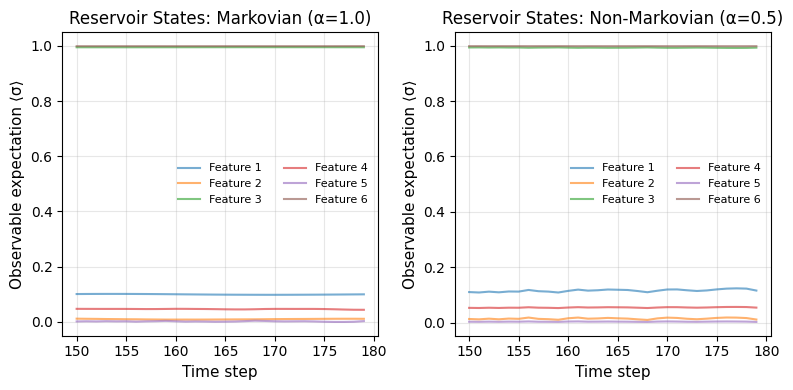

Note: Non-Markovian dynamics show richer temporal structure due to memory effects


In [ ]:
# Plot first few reservoir features over time
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Limit time range
time_start = 150
time_end = 250
time_steps = np.arange(len(X_train_markov))
time_mask = (time_steps >= time_start) & (time_steps <= time_end)
time_steps_plot = time_steps[time_mask]

n_features_plot = 6  # Plot first 6 features

# Markovian
for i in range(n_features_plot):
    axes[0].plot(time_steps_plot, X_train_markov[time_mask, i], alpha=0.6, label=f'Feature {i+1}')
axes[0].set_title('Reservoir States: Markovian (α=1.0)', fontsize=12)
axes[0].set_xlabel('Time step', fontsize=11)
axes[0].set_ylabel('Observable expectation ⟨σ⟩', fontsize=11)
axes[0].legend(fontsize=8, ncol=2, frameon=False)
axes[0].grid(True, alpha=0.3)

# Non-Markovian
for i in range(n_features_plot):
    axes[1].plot(time_steps_plot, X_train_nonmarkov[time_mask, i], alpha=0.6, label=f'Feature {i+1}')
axes[1].set_title('Reservoir States: Non-Markovian (α=0.5)', fontsize=12)
axes[1].set_xlabel('Time step', fontsize=11)
axes[1].set_ylabel('Observable expectation ⟨σ⟩', fontsize=11)
axes[1].legend(fontsize=8, ncol=2, frameon=False)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/reservoir_states_dynamics.pdf', dpi=300, bbox_inches='tight')
plt.show()

print("Note: Non-Markovian dynamics show richer temporal structure due to memory effects")

## Summary and Conclusions

### Architecture

This implementation combines:
1. **Fujii-Nakajima QRC**: Transverse-field Ising model with input encoding
2. **Time Subordination**: Introduces non-Markovian memory effects
3. **QuTiP Integration**: Efficient quantum state evolution

### Key Results

- **Markovian regime (α=1.0)**: Standard exponential relaxation
- **Non-Markovian regime (α<1.0)**: Power-law memory effects via Mittag-Leffler dynamics
- **Memory enhancement**: Non-Markovian dynamics can improve temporal processing tasks

### Physical Interpretation

The time subordination parameter α controls:
- **α = 1.0**: Memoryless Markovian dynamics
- **α < 1.0**: Anomalous subdiffusion with long-term memory
- **Smaller α**: Stronger memory effects and temporal correlations

### Applications

Non-Markovian QRC is particularly suited for:
- **Long-range temporal dependencies** (e.g., NARMA tasks)
- **Time series prediction** with memory requirements
- **Modeling biological systems** with non-exponential relaxation
- **Quantum sensing** with environmental memory

### References

1. Fujii, K., & Nakajima, K. (2017). "Harnessing Disordered-Ensemble Quantum Dynamics for Machine Learning." *Phys. Rev. Applied* 8, 024030.
2. Metzler, R., & Klafter, J. (2000). "The random walk's guide to anomalous diffusion: a fractional dynamics approach." *Phys. Rep.* 339(1), 1-77.
3. Nakajima, K., et al. (2015). "Physical reservoir computing—an introductory perspective." *Jpn. J. Appl. Phys.* 59, 060501.